# **BitePulse AI - Modeling: MS-TCN with Frame-Level Supervision**

* **Name/Group:** Aktham Almomani / Group 13

## **Introduction**

Instead of classifying short video windows with a heavy 3D-CNN, we move to an MS-TCN (Multi-Stage Temporal Convolutional Network) that operates on **frame-level pose features**. The original dataset has **16 action labels**, but for BitePulse we collapse them into a binary target: **INTAKE** (frames labeled *eat it*) vs **NON-INTAKE** (all other labels). The MS-TCN takes the full sequence of frame features and predicts this binary label at each time step, giving us a lightweight, sequence-aware model that we can later convert into bite events and pacing metrics.



## **Imports and basic setup**

In [4]:
# Required imports:
import collections
import itertools
import os
from pathlib import Path
import shutil
import sys
import time
from collections import Counter
import math
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)







In [2]:
# Mount Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Starting Fresh - Copy Original EastSense Dataset**

In [ ]:
# Set paths:
SRC = Path("/content/drive/MyDrive/eatsense")
DST = Path("/content/drive/MyDrive/eatsense_v1")


# Folders that we need - original EatSense data:
raw_dirs = [
    "rgb",
    "depth",
    "poses_true",
    "poses_fake",
    "true2d_parquet",
    "labels_v0",
    "all_misc",
    "test",
]

# Extras just in case:
raw_files = [
    "manifest_eatsense_rgb_true2d.csv",
    "segments_index_v0.parquet",
    "frames_index_v0.parquet",
    "splits_v0.csv",
    "fps_by_key.json",
]

# Copy folders:
for d in raw_dirs:
    src_d = SRC / d
    dst_d = DST / d
    if src_d.exists():
        print(f"Copying dir: {src_d} -> {dst_d}")
        shutil.copytree(src_d, dst_d)
    else:
        print(f"SKIP (dir not found): {src_d}")

# Copy files
for f in raw_files:
    src_f = SRC / f
    dst_f = DST / f
    if src_f.exists():
        print(f"Copying file: {src_f} -> {dst_f}")
        shutil.copy2(src_f, dst_f)
    else:
        print(f"SKIP (file not found): {src_f}")

print("\nDone. Clean raw copy is at:", DST)


Copying dir: /content/drive/MyDrive/eatsense/rgb -> /content/drive/MyDrive/eatsense_v1/rgb
Copying dir: /content/drive/MyDrive/eatsense/depth -> /content/drive/MyDrive/eatsense_v1/depth
Copying dir: /content/drive/MyDrive/eatsense/poses_true -> /content/drive/MyDrive/eatsense_v1/poses_true
Copying dir: /content/drive/MyDrive/eatsense/poses_fake -> /content/drive/MyDrive/eatsense_v1/poses_fake
Copying dir: /content/drive/MyDrive/eatsense/true2d_parquet -> /content/drive/MyDrive/eatsense_v1/true2d_parquet
Copying dir: /content/drive/MyDrive/eatsense/labels_v0 -> /content/drive/MyDrive/eatsense_v1/labels_v0
Copying dir: /content/drive/MyDrive/eatsense/all_misc -> /content/drive/MyDrive/eatsense_v1/all_misc
Copying dir: /content/drive/MyDrive/eatsense/test -> /content/drive/MyDrive/eatsense_v1/test
Copying file: /content/drive/MyDrive/eatsense/manifest_eatsense_rgb_true2d.csv -> /content/drive/MyDrive/eatsense_v1/manifest_eatsense_rgb_true2d.csv
Copying file: /content/drive/MyDrive/eatsens

In [ ]:
ROOT = Path("/content/drive/MyDrive/eatsense_v1")

for p in ROOT.iterdir():
    print(("[DIR] " if p.is_dir() else "[FILE]") + " ", p.name)


[DIR]   rgb
[DIR]   depth
[DIR]   poses_true
[DIR]   poses_fake
[DIR]   true2d_parquet
[DIR]   labels_v0
[DIR]   all_misc
[DIR]   test
[FILE]  manifest_eatsense_rgb_true2d.csv
[FILE]  segments_index_v0.parquet
[FILE]  frames_index_v0.parquet
[FILE]  splits_v0.csv
[FILE]  fps_by_key.json


## **Environment Setup and Data Schema Inspection**

In [15]:
# our roots:
base_path = '/content/drive/MyDrive/eatsense_v1'

if os.path.exists(base_path):
    print(f">>> Dataset root found at: {base_path}")
else:
    print(f">>> Dataset root NOT found at: {base_path}")
    sys.exit(1)

>>> Dataset root found at: /content/drive/MyDrive/eatsense_v1


In [ ]:
def locate_true_3d_files(base_path):
    # Constructing the path based on the raw structure tree
    true_3d_dir = os.path.join(base_path, 'poses_true', 'True3D')

    print(f"\n>>> [NAV] Locating True3D directory: {true_3d_dir}")

    if not os.path.exists(true_3d_dir):
        print(">>> 'poses_true/True3D' directory does not exist.")
        sys.exit(1)

    csv_files = sorted([f for f in os.listdir(true_3d_dir) if f.endswith('.csv')])

    if not csv_files:
        print(">>> No CSV files found in True3D directory.")
        sys.exit(1)

    print(f">>> Found {len(csv_files)} pose files.")
    print("    Sample filenames:")
    for f in csv_files[:3]:
        print(f"    - {f}")

    return true_3d_dir, csv_files

In [ ]:
def inspect_schema(file_dir, filename):
    full_path = os.path.join(file_dir, filename)
    print(f"\n>>> Loading file: {filename}")

    try:
        df = pd.read_csv(full_path)

        print("\n" + "="*60)
        print(f"DATA INSPECTION REPORT: {filename}")
        print("="*60)

        # 1. Dimensions:
        print(f"\n[1] Dimensions:")
        print(f"    Rows (Frames): {df.shape}")
        print(f"    Columns (Features): {df.shape[1]}")

        # 2. Column Headers:
        print(f"\n[2] Column Headers:")
        print(f"    {df.columns.tolist()}")

        # 3. Data Types:
        print(f"\n[3] Data Types Summary:")
        print(df.dtypes.value_counts())

        # 4. Null Value Check (Critical for back-projection validity):
        null_counts = df.isnull().sum()
        total_nulls = null_counts.sum()
        print(f"\n[4] Missing Data Check:")
        if total_nulls == 0:
            print("    No missing values detected.")
        else:
            print(f"    WARNING: {total_nulls} missing values detected.")
            print(null_counts[null_counts > 0])

        # 5. Label Identification Strategy:
        # Searching for columns that might contain the 'Action' labels:
        label_keywords = ['label', 'action', 'class', 'annotation', 'ground_truth']
        potential_labels = [c for c in df.columns if any(k in c.lower() for k in label_keywords)]

        print(f"\n[5] Label Column Identification:")
        if potential_labels:
            print(f"    Potential label columns found: {potential_labels}")
            for col in potential_labels:
                unique_vals = df[col].unique()
                print(f"    Unique values in '{col}' ({len(unique_vals)}): {unique_vals[:10]}...")
        else:
            print("    WARNING: No explicit label column found based on keywords.")
            print("    Check if labels are in a separate file or encoded in the filename.")

        # 6. Data Sample:
        print(f"\n[6] Head (First 5 Rows):")
        print(df.head())
        print("="*60)

    except Exception as e:
        print(f">>> Could not read CSV: {e}")

In [ ]:
if __name__ == "__main__":
    dataset_root = '/content/drive/MyDrive/eatsense_v1'

    # Locate Target Files:
    target_dir, file_list = locate_true_3d_files(dataset_root)

    # Testing the schema:
    test_filename = file_list[0]

    print(f"\n>>> Selected test file: {test_filename}")

    # Run Inspection on that SINGLE file:
    inspect_schema(target_dir, test_filename)


>>> [NAV] Locating True3D directory: /content/drive/MyDrive/eatsense_v1/poses_true/True3D
>>> Found 135 pose files.
    Sample filenames:
    - 20210518_230219.csv
    - 20210523_202300.csv
    - 20210529_150552.csv

>>> Selected test file: 20210518_230219.csv

>>> Loading file: 20210518_230219.csv

DATA INSPECTION REPORT: 20210518_230219.csv

[1] Dimensions:
    Rows (Frames): (3668, 28)
    Columns (Features): 28

[2] Column Headers:
    ['Unnamed: 0', 'Project', 'Action', 'Imgs', 'head_x', 'head_y', 'head_z', 'Mid-Shoulder_x', 'Mid-Shoulder_y', 'Mid-Shoulder_z', 'Right-Shoulder_x', 'Right-Shoulder_y', 'Right-Shoulder_z', 'Right-Elbow_x', 'Right-Elbow_y', 'Right-Elbow_z', 'Right-Wrist_x', 'Right-Wrist_y', 'Right-Wrist_z', 'Left-shoulder_x', 'Left-shoulder_y', 'Left-shoulder_z', 'Left-Elbow_x', 'Left-Elbow_y', 'Left-Elbow_z', 'Left-Wrist_x', 'Left-Wrist_y', 'Left-Wrist_z']

[3] Data Types Summary:
float64    24
int64       2
object      2
Name: count, dtype: int64

[4] Missing Data C

## **Define Input and Output Paths**

First, let's define the base path for the dataset, the input directory for `poses_true/True3D` CSVs, and create output directories for the processed feature (`.npy`) and label (`.txt`) files.


In [5]:
# Our Dataset root:
dataset_root = Path('/content/drive/MyDrive/eatsense_v1')

# Let's build the input directory path for poses_true/True3D CSVs:
true_3d_input_dir = dataset_root / 'poses_true' / 'True3D'

# Here, let's define the output directory path for processed feature files:
features_output_dir = dataset_root / 'processed_data' / 'features'

# Then let's define the output directory path for processed label files:
labels_output_dir = dataset_root / 'processed_data' / 'labels'

# Finally, let's create the output directories if they don't exist:
features_output_dir.mkdir(parents=True, exist_ok=True)
labels_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Dataset Root: {dataset_root}")
print(f"True3D Input Directory: {true_3d_input_dir}")
print(f"Features Output Directory: {features_output_dir}")
print(f"Labels Output Directory: {labels_output_dir}")
print("Output directories created/verified.")

Dataset Root: /content/drive/MyDrive/eatsense_v1
True3D Input Directory: /content/drive/MyDrive/eatsense_v1/poses_true/True3D
Features Output Directory: /content/drive/MyDrive/eatsense_v1/processed_data/features
Labels Output Directory: /content/drive/MyDrive/eatsense_v1/processed_data/labels
Output directories created/verified.


## **Process and Convert True3D Data**


Alright, here let's iterate through each CSV file in the `poses_true/True3D` directory. For each file, let's load it, extract the coordinate columns as features, and the 'Action' column as labels. Convert the features to an array and save it as a `.npy` file. Save the labels as a plain text file, with each label on a new line.


In [ ]:
# Alright, let's list of all CSV files in the true_3d_input_dir:
csv_files = sorted([f for f in os.listdir(true_3d_input_dir) if f.endswith('.csv')])

processed_count = 0
print(f"\n>>> Starting processing of {len(csv_files)} CSV files...")

for csv_file in csv_files:
    full_csv_path = true_3d_input_dir / csv_file
    print(f"    Processing: {csv_file}")

    # Load the CSV file into df:
    df = pd.read_csv(full_csv_path)

    # Define columns to exclude from features:
    exclude_cols = ['Unnamed: 0', 'Project', 'Action', 'Imgs']
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    # Extract coordinate columns as features and convert to array:
    features = df[feature_cols].to_numpy()

    # Extract 'Action' column as labels:
    labels = df['Action'].tolist()

    # Define output filenames:
    base_filename = csv_file.replace('.csv', '')
    feature_output_filename = f"{base_filename}.npy"
    label_output_filename = f"{base_filename}.txt"

    # Save features as .npy file:
    np.save(features_output_dir / feature_output_filename, features)

    # Save labels as a text file (one label per line):
    with open(labels_output_dir / label_output_filename, 'w') as f:
        for label in labels:
            f.write(f"{label}\n")

    processed_count += 1

print(f"\n>>> Successfully processed {processed_count} files.")
print(f"Features saved to: {features_output_dir}")
print(f"Labels saved to: {labels_output_dir}")


>>> Starting processing of 135 CSV files...
    Processing: 20210518_230219.csv
    Processing: 20210523_202300.csv
    Processing: 20210529_150552.csv
    Processing: 20210529_153708.csv
    Processing: 20210530_153343.csv
    Processing: 20210531_150448.csv
    Processing: 20210603_130948.csv
    Processing: 20210605_155355.csv
    Processing: 20210606_154234.csv
    Processing: 20210607_152559.csv
    Processing: 20210607_154140.csv
    Processing: 20210608_163819.csv
    Processing: 20210609_154241.csv
    Processing: 20210609_215756.csv
    Processing: 20210609_220502.csv
    Processing: 20210609_221133.csv
    Processing: 20210610_144155.csv
    Processing: 20210610_230110.csv
    Processing: 20210616_163847.csv
    Processing: 20210616_170258.csv
    Processing: 20210617_165755.csv
    Processing: 20210617_224119.csv
    Processing: 20210620_150313.csv
    Processing: 20210620_230306.csv
    Processing: 20210620_230707.csv
    Processing: 20210621_125816.csv
    Processing: 202

## **Verify Converted Files**

Now, let's verify by listing the contents of the newly created feature (.npy) and label (.txt) directories to confirm that the conversion process was successful and the files are correctly generated.


In [6]:
# List contents of the features_output_dir:
print(f"\n>>> Contents of {features_output_dir}:")
feature_files = sorted(os.listdir(features_output_dir))
if feature_files:
    print(f"Found {len(feature_files)} feature files. Sample filenames:")
    for f in feature_files[:5]:
        print(f"    - {f}")
else:
    print("No feature files found.")

# List contents of the labels_output_dir:
print(f"\n>>> Contents of {labels_output_dir}:")
label_files = sorted(os.listdir(labels_output_dir))
if label_files:
    print(f"    Found {len(label_files)} label files. Sample filenames:")
    for f in label_files[:5]:
        print(f"    - {f}")
else:
    print("No label files found.")

# load and inspect one .npy file and one .txt file:
if feature_files and label_files:
    sample_feature_file = features_output_dir / feature_files[0]
    sample_label_file = labels_output_dir / label_files[0]

    print(f"\n>>> Inspecting sample feature file: {sample_feature_file.name}")
    loaded_features = np.load(sample_feature_file)
    print(f"Shape: {loaded_features.shape}")
    print(f"First 5 rows:\n{loaded_features[:5]}")

    print(f"\n>>> Inspecting sample label file: {sample_label_file.name}")
    with open(sample_label_file, 'r') as f:
        loaded_labels = [line.strip() for line in f.readlines()]
    print(f"Total labels: {len(loaded_labels)}")
    print(f"First 10 labels: {loaded_labels[:10]}")
else:
    print("\nSkipping sample file inspection as no files were found.")


>>> Contents of /content/drive/MyDrive/eatsense_v1/processed_data/features:
Found 135 feature files. Sample filenames:
    - 20210518_230219.npy
    - 20210523_202300.npy
    - 20210529_150552.npy
    - 20210529_153708.npy
    - 20210530_153343.npy

>>> Contents of /content/drive/MyDrive/eatsense_v1/processed_data/labels:
    Found 135 label files. Sample filenames:
    - 20210518_230219.txt
    - 20210523_202300.txt
    - 20210529_150552.txt
    - 20210529_153708.txt
    - 20210530_153343.txt

>>> Inspecting sample feature file: 20210518_230219.npy
Shape: (3668, 24)
First 5 rows:
[[ 0.67282104  0.4706485   2.0150001   0.64617854  0.45228249  2.17800021
   0.80287057  0.44098946  2.19200015  0.88601834  0.24337713  2.37700009
   0.89125431  0.0247308   2.45500016  0.51552123  0.48631701  2.25400019
   0.46310815  0.31562111  2.46000004  0.4288637   0.0614443   2.66800022]
 [ 0.64927858  0.47643125  2.05400014  0.61270493  0.45266983  2.19700003
   0.75192106  0.44170031  2.17800021  0

## MS-TCN model: Frame-Level

Now we'll build an MS-TCN model **from scratch** for frame-level intake detection. The plan:

1. **Prepare frame-level labels**  
   Build a `FrameDataset` and `collate_fn` that load pose features, create one label per frame, and pad variable-length sequences (using `-100` as the ignore index).

2. **Define the MS-TCN architecture**  
   Implement a multi-stage temporal CNN that takes frame sequences as input and outputs a class logit for every frame (INTAKE vs NON_INTAKE).

3. **Handle class imbalance**  
   Compute class frequencies from the training set and use a **class-weighted `nn.CrossEntropyLoss`** so rare INTAKE frames get higher weight.

4. **Write the training loop**  
   Train MS-TCN on batches of sequences: forward pass &rarr; frame-level loss &rarr; backprop &rarr; optimizer step, with validation at the end of each epoch.

5. **Add evaluation utilities**  
   Flatten frame-level predictions and labels to compute accuracy, precision, recall, F1, ROC AUC, PR AUC, and a confusion matrix.

6. **Visualize performance**  
   Plot **frame-level confusion matrix**, **ROC curve**, and **Precision-Recall curve** and interpret where the model does well or struggles.

7. **Document the changes**  
   Summarize the full MS-TCN pipeline (data &rarr; model &rarr; training &rarr; metrics) and how it improves over the earlier window-based TCN setup.


### **Modify Dataset for Frame-Level Labels**


Here, let's update the MSTCNDataset to ensure it correctly loads and prepares frame-level labels (one label per frame) for each sequence, rather than aggregating them for sequence-level classification.


In [7]:
# Re-load all unique labels:
all_unique_labels = set()
label_files_for_mapping = sorted(os.listdir(labels_output_dir))
for label_file in label_files_for_mapping:
    with open(labels_output_dir / label_file, 'r') as f:
        for line in f:
            all_unique_labels.add(line.strip())

sorted_unique_labels = sorted(list(all_unique_labels))
print(f"Found {len(sorted_unique_labels)} raw labels: {sorted_unique_labels}")

# Define binary mapping: NON_INTAKE = 0, INTAKE = 1
INTAKE_LABELS = {"eat it"}

label_to_id = {
    "NON_INTAKE": 0,
    "INTAKE": 1
}
id_to_label = {v: k for k, v in label_to_id.items()}

print("Binary label_to_id:", label_to_id)
print("Binary id_to_label:", id_to_label)


# Custom Dataset that binarizes frame-level labels:
class MSTCNDataset(Dataset):
    def __init__(self, features_dir, labels_dir, label_to_id, intake_labels):
        self.features_dir = features_dir
        self.labels_dir = labels_dir
        self.label_to_id = label_to_id
        self.intake_labels = intake_labels

        # Get sorted list of all file names:
        self.filenames = sorted([f.stem for f in Path(features_dir).glob('*.npy')])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]

        # Load features:
        features_path = self.features_dir / f"{filename}.npy"
        features = np.load(features_path)
        features_tensor = torch.from_numpy(features).float()   # (T, F)
        features_tensor = features_tensor.transpose(0, 1)      # (F, T) for Conv1d

        # Load original string labels:
        labels_path = self.labels_dir / f"{filename}.txt"
        with open(labels_path, 'r') as f:
            raw_labels = [line.strip() for line in f]

        # Map each raw label to binary 0/1:
        numerical_labels = [
            self.label_to_id["INTAKE"] if lbl in self.intake_labels
            else self.label_to_id["NON_INTAKE"]
            for lbl in raw_labels
        ]

        labels_tensor = torch.tensor(numerical_labels, dtype=torch.long)  # (T,)
        return features_tensor, labels_tensor


def collate_fn(batch):
    max_seq_len = max([item[0].shape[1] for item in batch])

    padded_features = []
    padded_labels = []

    for features, labels in batch:
        pad_amount_features = max_seq_len - features.shape[1]
        padded_features.append(F.pad(features, (0, pad_amount_features), 'constant', 0))

        pad_amount_labels = max_seq_len - labels.shape[0]
        padded_labels.append(F.pad(labels, (0, pad_amount_labels), 'constant', -100))

    batch_features = torch.stack(padded_features)
    batch_labels = torch.stack(padded_labels)

    return batch_features, batch_labels


# Instantiate dataset & dataloader:
mstcn_dataset = MSTCNDataset(
    features_output_dir,
    labels_output_dir,
    label_to_id=label_to_id,
    intake_labels=INTAKE_LABELS,
)

batch_size = 2
mstcn_dataloader = DataLoader(
    mstcn_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)

print(f"\nMSTCNDataset created with {len(mstcn_dataset)} samples.")
print(f"DataLoader created with batch size {batch_size}.")

# Test loading a batch:
for batch_features, batch_labels in mstcn_dataloader:
    print(f"\nSample Batch Features shape: {batch_features.shape}")
    print(f"Sample Batch Labels shape: {batch_labels.shape}")
    print("Sample Batch Labels (first sample, first 20 frames):", batch_labels[0, :20])
    break

print("Data loading utilities successfully prepared with binary frame-level labels.")


Found 16 raw labels: ['chewing', 'drink', 'eat it', 'food in hand at table', 'move hand away from mouth', 'move hand towards mouth', 'no action', 'other', 'pick food from utensil with both hands', 'pick food from utensil with one hand', 'pick food from utensil with tool in one hand', 'pick food from utensil with tools in both hands', 'pick up a cup/glass', 'pick up tools with both hands', 'put one tool back', 'put the cup/glass back']
Binary label_to_id: {'NON_INTAKE': 0, 'INTAKE': 1}
Binary id_to_label: {0: 'NON_INTAKE', 1: 'INTAKE'}

MSTCNDataset created with 135 samples.
DataLoader created with batch size 2.

Sample Batch Features shape: torch.Size([2, 24, 9949])
Sample Batch Labels shape: torch.Size([2, 9949])
Sample Batch Labels (first sample, first 20 frames): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Data loading utilities successfully prepared with binary frame-level labels.


### **Intake & NON-Take Distribution in Frame-Level**

In [8]:
frame_counts = Counter()

label_files = sorted((labels_output_dir).glob("*.txt"))
for label_path in label_files:
    with open(label_path, "r") as f:
        for line in f:
            raw_label = line.strip()
            binary_name = "INTAKE" if raw_label in INTAKE_LABELS else "NON_INTAKE"
            frame_counts[binary_name] += 1

total_frames = sum(frame_counts.values())

print("Frame counts (all files):")
for cls in ["INTAKE", "NON_INTAKE"]:
    count = frame_counts[cls]
    pct = 100.0 * count / total_frames if total_frames > 0 else 0.0
    print(f"{cls}: {count} frames ({pct:.2f}%)")

print(f"\nTotal frames across all files: {total_frames}")


Frame counts (all files):
INTAKE: 34287 frames (4.83%)
NON_INTAKE: 675540 frames (95.17%)

Total frames across all files: 709827


In [9]:
per_file_counts = {}

for label_path in label_files:
    file_counter = Counter()
    with open(label_path, "r") as f:
        for line in f:
            raw_label = line.strip()
            binary_name = "INTAKE" if raw_label in INTAKE_LABELS else "NON_INTAKE"
            file_counter[binary_name] += 1
    per_file_counts[label_path.stem] = file_counter

for fname, cnt in sorted(per_file_counts.items()):
    total = sum(cnt.values())
    intake = cnt.get("INTAKE", 0)
    non_intake = cnt.get("NON_INTAKE", 0)
    print(
        f"{fname}: INTAKE={intake} ({intake/total:.2%}), "
        f"NON_INTAKE={non_intake} ({non_intake/total:.2%}), total={total}"
    )


20210518_230219: INTAKE=206 (5.62%), NON_INTAKE=3462 (94.38%), total=3668
20210523_202300: INTAKE=363 (6.72%), NON_INTAKE=5042 (93.28%), total=5405
20210529_150552: INTAKE=1055 (14.07%), NON_INTAKE=6443 (85.93%), total=7498
20210529_153708: INTAKE=0 (0.00%), NON_INTAKE=1395 (100.00%), total=1395
20210530_153343: INTAKE=490 (9.65%), NON_INTAKE=4590 (90.35%), total=5080
20210531_150448: INTAKE=763 (13.94%), NON_INTAKE=4711 (86.06%), total=5474
20210603_130948: INTAKE=136 (1.79%), NON_INTAKE=7480 (98.21%), total=7616
20210605_155355: INTAKE=285 (7.76%), NON_INTAKE=3389 (92.24%), total=3674
20210606_154234: INTAKE=440 (9.00%), NON_INTAKE=4450 (91.00%), total=4890
20210607_152559: INTAKE=283 (11.21%), NON_INTAKE=2241 (88.79%), total=2524
20210607_154140: INTAKE=0 (0.00%), NON_INTAKE=2534 (100.00%), total=2534
20210608_163819: INTAKE=137 (1.90%), NON_INTAKE=7056 (98.10%), total=7193
20210609_154241: INTAKE=513 (8.48%), NON_INTAKE=5539 (91.52%), total=6052
20210609_215756: INTAKE=142 (2.42%),

**Summary Highlights:**

* Out of 135 videos, 4 sessions had 0% INTAKE (no "eat it" frames).
* We kept these files because they still provide valid NON-INTAKE behavior (talking, hand movements, background motion) that the model must learn to ignore.
* Removing them would inflate the apparent intake rate and bias the dataset toward “eating” clips, making real-world performance less realistic.
* Including true "no-intake” sessions also gives a harder, more honest evaluation, since the model must correctly return zero bites for some videos.

In [10]:
features_output_dir = Path(features_output_dir)
labels_output_dir = Path(labels_output_dir)

all_feature_files = sorted(features_output_dir.glob("*.npy"))
all_filenames = [f.stem for f in all_feature_files]

per_file_stats = []

for fname in all_filenames:
    label_path = labels_output_dir / f"{fname}.txt"
    cnt = Counter()
    with open(label_path, "r") as f:
        for line in f:
            raw_label = line.strip()
            cls_name = "INTAKE" if raw_label in INTAKE_LABELS else "NON_INTAKE"
            cnt[cls_name] += 1
    intake = cnt["INTAKE"]
    non_intake = cnt["NON_INTAKE"]
    total = intake + non_intake
    ratio = intake / total if total > 0 else 0.0
    per_file_stats.append(
        {"filename": fname, "intake": intake, "non_intake": non_intake,
         "total": total, "ratio": ratio}
    )

# Sanity:
global_intake = sum(s["intake"] for s in per_file_stats)
global_total = sum(s["total"] for s in per_file_stats)
print(f"Global INTAKE%: {100 * global_intake / global_total:.2f}%")


Global INTAKE%: 4.83%


**Summary Highlights:**

* With frame-level labels, about 5% of frames are INTAKE, vs only 0.4% positive windows in the earlier pose-TCN setup.
* This means the class imbalance is still strong but less extreme, giving MS-TCN a richer positive signal to learn from.
* Practically, we now see more “eat it” examples per video, which should help the model better capture the timing and shape of intake events.

### **Splite: Train, Test, Val**

In [11]:
ratios = np.array([s["ratio"] for s in per_file_stats])
bins = [0.0, 0.01, 0.03, 0.06, 0.10, 1.0]
ratio_bins = np.digitize(ratios, bins)

filenames = np.array([s["filename"] for s in per_file_stats])

# splits ( 70 / 15 / 15):
test_size = 0.15
val_size = 0.15
train_size = 1.0 - test_size - val_size

# Stratified train vs temp (val+test):
sss1 = StratifiedShuffleSplit(
    n_splits=1,
    test_size=(val_size + test_size),
    random_state=42
)
train_idx, temp_idx = next(sss1.split(filenames, ratio_bins))

X_train = filenames[train_idx]
y_train_bins = ratio_bins[train_idx]

X_temp = filenames[temp_idx]
y_temp_bins = ratio_bins[temp_idx]

# Random val vs test from temp:
relative_test_size = test_size / (test_size + val_size)
X_val, X_test, y_val_bins, y_test_bins = train_test_split(
    X_temp,
    y_temp_bins,
    test_size=relative_test_size,
    random_state=43,
    shuffle=True,
    stratify=None,
)

print(f"Train files: {len(X_train)}, Val files: {len(X_val)}, Test files: {len(X_test)}")

# let's check intake% in each split:
def split_intake_ratio(filenames_subset):
    intake = 0
    total = 0
    lookup = {s["filename"]: s for s in per_file_stats}
    for fn in filenames_subset:
        stats = lookup[fn]
        intake += stats["intake"]
        total += stats["total"]
    return 100 * intake / total

print(f"Train INTAKE%: {split_intake_ratio(X_train):.2f}")
print(f"Val   INTAKE%: {split_intake_ratio(X_val):.2f}")
print(f"Test  INTAKE%: {split_intake_ratio(X_test):.2f}")


Train files: 94, Val files: 20, Test files: 21
Train INTAKE%: 4.78
Val   INTAKE%: 5.82
Test  INTAKE%: 3.98


### **MS-TCN Model Training**

In [12]:
class MSTCNDataset(Dataset):
    def __init__(self, features_dir, labels_dir, label_to_id, intake_labels, filenames):
        self.features_dir = Path(features_dir)
        self.labels_dir = Path(labels_dir)
        self.label_to_id = label_to_id
        self.intake_labels = intake_labels
        self.filenames = sorted(list(filenames))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]

        # Load features:
        features_path = self.features_dir / f"{filename}.npy"
        features = np.load(features_path)
        features_tensor = torch.from_numpy(features).float()  # (T, F)
        features_tensor = features_tensor.transpose(0, 1)     # (F, T)

        # Load frame-level labels:
        labels_path = self.labels_dir / f"{filename}.txt"
        with open(labels_path, "r") as f:
            raw_labels = [line.strip() for line in f]

        # Map to binary classes:
        numerical_labels = [
            self.label_to_id["INTAKE"] if lbl in self.intake_labels
            else self.label_to_id["NON_INTAKE"]
            for lbl in raw_labels
        ]
        labels_tensor = torch.tensor(numerical_labels, dtype=torch.long)  # (T,)

        return features_tensor, labels_tensor


In [13]:
batch_size = 2

train_dataset = MSTCNDataset(features_output_dir, labels_output_dir,
                             label_to_id, INTAKE_LABELS, X_train)
val_dataset   = MSTCNDataset(features_output_dir, labels_output_dir,
                             label_to_id, INTAKE_LABELS, X_val)
test_dataset  = MSTCNDataset(features_output_dir, labels_output_dir,
                             label_to_id, INTAKE_LABELS, X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Test samples:  {len(test_dataset)}")


Train samples: 94
Val samples:   20
Test samples:  21


In [16]:
import collections

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_to_id)

label_counts = collections.defaultdict(int)

for fname in X_train:
    labels_path = labels_output_dir / f"{fname}.txt"
    with open(labels_path, "r") as f:
        for line in f:
            raw_label = line.strip()
            cls_name = "INTAKE" if raw_label in INTAKE_LABELS else "NON_INTAKE"
            cls_id = label_to_id[cls_name]
            label_counts[cls_id] += 1

class_frequencies = torch.zeros(num_classes, dtype=torch.float32)
for label_id, count in label_counts.items():
    class_frequencies[label_id] = count

total_samples_in_labels = class_frequencies.sum()
class_weights = total_samples_in_labels / (class_frequencies * num_classes)
class_weights[class_frequencies == 0] = 0.0
class_weights = class_weights.to(device)

print("Train class frequencies:", class_frequencies)
print("Train class weights:", class_weights)


Train class frequencies: tensor([481052.,  24169.])
Train class weights: tensor([ 0.5251, 10.4518], device='cuda:0')


In [18]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(ConvBlock, self).__init__()
        padding = self._calculate_padding(kernel_size, dilation)
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=padding,
            dilation=dilation
        )
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def _calculate_padding(self, kernel_size, dilation):
        return dilation * (kernel_size - 1) // 2

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class DilatedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(DilatedResidualBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size, dilation)
        self.conv2 = ConvBlock(out_channels, out_channels, kernel_size, dilation)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        if self.downsample:
            residual = self.downsample(residual)

        out = self.conv1(x)
        out = self.conv2(out)
        return out + residual

class SingleStageTCN(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, kernel_size):
        super(SingleStageTCN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            # Increase dilation factor for each layer
            dilation = 2 ** i
            self.layers.append(
                DilatedResidualBlock(in_channels if i == 0 else out_channels, out_channels, kernel_size, dilation)
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Here's the main MS_TCN class:
class MS_TCN(nn.Module):
    def __init__(self, num_stages, num_layers_per_stage, in_features, num_classes, kernel_size=3):
        super(MS_TCN, self).__init__()
        self.num_stages = num_stages
        self.stages = nn.ModuleList()
        # The number of channels output by each stage:
        stage_out_channels = 64

        # Initial convolution to project input features to stage_out_channels:
        self.initial_conv = nn.Conv1d(in_features, stage_out_channels, kernel_size=1)

        for s in range(num_stages):
            self.stages.append(
                SingleStageTCN(num_layers_per_stage, stage_out_channels, stage_out_channels, kernel_size)
            )

        # Output layer for frame-level classification: 1x1 convolution:
        self.output_conv = nn.Conv1d(stage_out_channels, num_classes, kernel_size=1)

    def forward(self, x):
        # (batch_size, in_features, sequence_length)
        # Initial convolution:
        x = self.initial_conv(x)

        for stage in self.stages:
            x = stage(x)

        # Apply 1x1 convolution for frame-level classification
        # Output = (batch_size, num_classes, sequence_length)
        out = self.output_conv(x)
        return out

# Re-instantiate the model with the new architecture:
in_features = mstcn_dataset[0][0].shape[0]
num_classes = len(label_to_id) # Number of unique labels

# Define model hyperparameters:
num_stages = 2
num_layers_per_stage = 5

model = MS_TCN(num_stages, num_layers_per_stage, in_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def train_model_frame_level(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=50,
    patience=5,
    min_delta=0.0,
    checkpoint_path=None,
):
    """
    Frame-level training with early stopping on validation loss.
    - patience: number of epochs with no improvement before stopping
    - min_delta: minimum change in val loss to qualify as improvement
    """

    print(f"\nStarting frame-level training for up to {num_epochs} epochs...")
    best_val_loss = math.inf
    best_model_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # ---------- TRAIN ----------
        model.train()
        epoch_loss = 0.0
        start_time = time.time()

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(features)                      # (B, C, T)
            outputs_reshaped = outputs.permute(0, 2, 1)   # (B, T, C)
            outputs_flat = outputs_reshaped.reshape(-1, num_classes)
            labels_flat = labels.reshape(-1)

            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)

        # VALIDATION:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)
                outputs_reshaped = outputs.permute(0, 2, 1)
                outputs_flat = outputs_reshaped.reshape(-1, num_classes)
                labels_flat = labels.reshape(-1)

                loss = criterion(outputs_flat, labels_flat)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Time: {elapsed:.2f}s"
        )

        # EARLY STOPPING CHECK:
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0

            # checkpoint:
            if checkpoint_path is not None:
                torch.save(best_model_state, checkpoint_path)
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print(
                    f"\nEarly stopping triggered after {epoch+1} epochs "
                    f"(best val loss = {best_val_loss:.4f})."
                )
                break

    # Restore best model weights
    model.load_state_dict(best_model_state)
    print("Frame-level training complete. Best model restored.")

    return model

In [20]:
checkpoint_path = "best_mstcn_frame_level_1.pth"

model = MS_TCN(num_stages, num_layers_per_stage, in_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = train_model_frame_level(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=50,
    patience=5,
    min_delta=0.0,
    checkpoint_path=checkpoint_path,
)



Starting frame-level training for up to 50 epochs...
Epoch 1/50 | Train Loss: 0.5803 | Val Loss: 0.5910 | Time: 89.07s
Epoch 2/50 | Train Loss: 0.4007 | Val Loss: 0.7098 | Time: 2.01s
  No improvement for 1 epoch(s).
Epoch 3/50 | Train Loss: 0.3604 | Val Loss: 0.7582 | Time: 1.79s
  No improvement for 2 epoch(s).
Epoch 4/50 | Train Loss: 0.3046 | Val Loss: 0.4631 | Time: 1.66s
Epoch 5/50 | Train Loss: 0.3159 | Val Loss: 0.6278 | Time: 1.68s
  No improvement for 1 epoch(s).
Epoch 6/50 | Train Loss: 0.2893 | Val Loss: 0.3101 | Time: 1.64s
Epoch 7/50 | Train Loss: 0.3182 | Val Loss: 0.3566 | Time: 1.57s
  No improvement for 1 epoch(s).
Epoch 8/50 | Train Loss: 0.2996 | Val Loss: 0.6153 | Time: 1.57s
  No improvement for 2 epoch(s).
Epoch 9/50 | Train Loss: 0.2752 | Val Loss: 0.3841 | Time: 1.60s
  No improvement for 3 epoch(s).
Epoch 10/50 | Train Loss: 0.2521 | Val Loss: 0.3384 | Time: 1.62s
  No improvement for 4 epoch(s).
Epoch 11/50 | Train Loss: 0.2721 | Val Loss: 0.4506 | Time: 1.6

In [21]:
def train_model_frame_level(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=50,
    patience=5,
    min_delta=0.0,
    checkpoint_path=None,
):
    """
    Frame-level training with early stopping on validation loss.
    Returns:
      - model (restored to best val loss)
      - history = {"train_loss": [...], "val_loss": [...]}
    """
    print(f"\nStarting frame-level training for up to {num_epochs} epochs...")
    best_val_loss = math.inf
    best_model_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Train:
        model.train()
        epoch_loss = 0.0
        start_time = time.time()

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(features)                      # (B, C, T)
            outputs_reshaped = outputs.permute(0, 2, 1)   # (B, T, C)
            outputs_flat = outputs_reshaped.reshape(-1, num_classes)
            labels_flat = labels.reshape(-1)

            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # VALIDATION:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)
                outputs_reshaped = outputs.permute(0, 2, 1)
                outputs_flat = outputs_reshaped.reshape(-1, num_classes)
                labels_flat = labels.reshape(-1)

                loss = criterion(outputs_flat, labels_flat)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Time: {elapsed:.2f}s"
        )

        # EARLY STOPPING CHECK:
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0

            if checkpoint_path is not None:
                torch.save(best_model_state, checkpoint_path)
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print(
                    f"\nEarly stopping triggered after {epoch+1} epochs "
                    f"(best val loss = {best_val_loss:.4f})."
                )
                break

    # Restore best model weights:
    model.load_state_dict(best_model_state)
    print("Frame-level training complete. Best model restored.")

    history = {"train_loss": train_losses, "val_loss": val_losses}
    return model, history



Starting frame-level training for up to 50 epochs...
Epoch 1/50 | Train Loss: 0.5611 | Val Loss: 0.8353 | Time: 1.61s
Epoch 2/50 | Train Loss: 0.3704 | Val Loss: 0.5865 | Time: 1.60s
Epoch 3/50 | Train Loss: 0.3814 | Val Loss: 0.5415 | Time: 1.66s
Epoch 4/50 | Train Loss: 0.3657 | Val Loss: 0.6774 | Time: 1.62s
  No improvement for 1 epoch(s).
Epoch 5/50 | Train Loss: 0.3267 | Val Loss: 0.3543 | Time: 1.62s
Epoch 6/50 | Train Loss: 0.3174 | Val Loss: 0.3840 | Time: 1.62s
  No improvement for 1 epoch(s).
Epoch 7/50 | Train Loss: 0.3249 | Val Loss: 0.3510 | Time: 1.61s
Epoch 8/50 | Train Loss: 0.3394 | Val Loss: 0.6263 | Time: 1.66s
  No improvement for 1 epoch(s).
Epoch 9/50 | Train Loss: 0.2966 | Val Loss: 0.4282 | Time: 1.61s
  No improvement for 2 epoch(s).
Epoch 10/50 | Train Loss: 0.3140 | Val Loss: 0.3255 | Time: 1.65s
Epoch 11/50 | Train Loss: 0.2804 | Val Loss: 0.5677 | Time: 1.64s
  No improvement for 1 epoch(s).
Epoch 12/50 | Train Loss: 0.2596 | Val Loss: 0.4830 | Time: 1.60

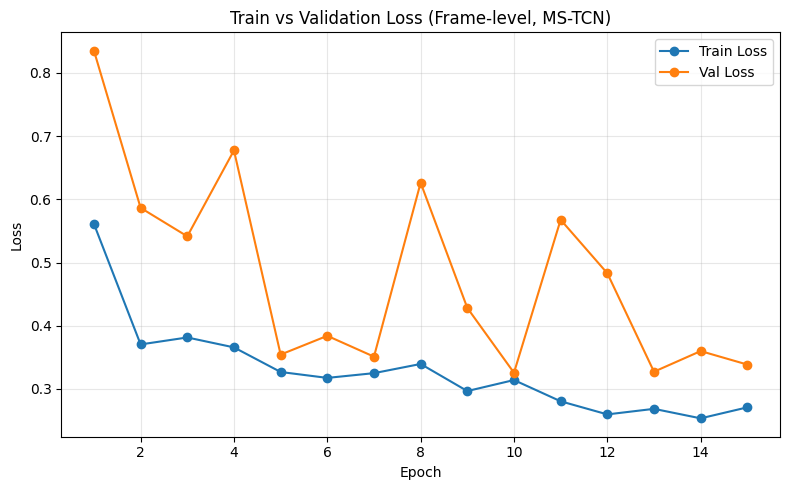

In [22]:
checkpoint_path = "best_mstcn_frame_level.pth"

model = MS_TCN(num_stages, num_layers_per_stage, in_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model, history = train_model_frame_level(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=50,
    patience=5,
    min_delta=0.0,
    checkpoint_path=checkpoint_path,
)

# Plot train vs val loss:
train_losses = history["train_loss"]
val_losses = history["val_loss"]
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker="o", label="Train Loss")
plt.plot(epochs, val_losses, marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Frame-level, MS-TCN)")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)  # (B, T) with -100 for padding

        outputs = model(features)   # (B, C, T)
        preds = outputs.argmax(dim=1)  # (B, T), class indices

        # Mask out padded positions
        mask = labels != -100

        true_flat = labels[mask].cpu().numpy()
        pred_flat = preds[mask].cpu().numpy()

        all_true.append(true_flat)
        all_pred.append(pred_flat)

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

print("True labels shape:", y_true.shape)
print("Pred labels shape:", y_pred.shape)


True labels shape: (97294,)
Pred labels shape: (97294,)


### **Model Performance Evaluation**

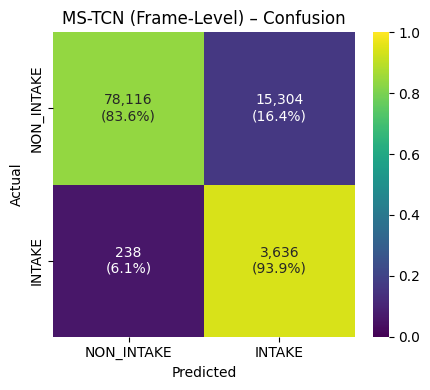

In [35]:
# Class names in the correct order
class_names = [id_to_label[0], id_to_label[1]]  # ["NON_INTAKE", "INTAKE"]

# Confusion matrix (float):
cm = confusion_matrix(y_true, y_pred, labels=[0, 1]).astype(float)

# Row-wise percentages (per true class):
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1.0
cm_percent = cm / row_sums

# Annotation:
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = int(cm[i, j])
        pct = cm_percent[i, j] * 100.0
        annot[i, j] = f"{count:,}\n({pct:0.1f}%)"

plt.figure(figsize=(4.5, 4))
ax = sns.heatmap(
    cm_percent,
    annot=annot,
    fmt="",
    cmap="viridis",
    vmin=0.0,
    vmax=1.0,
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": ""},
)

ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("MS-TCN (Frame-Level) – Confusion")
plt.tight_layout()
plt.show()


In [25]:
# class_names in the same order as class indices
class_names = [id_to_label[0], id_to_label[1]]  # ["NON_INTAKE", "INTAKE"]

# Overall accuracy:
accuracy = accuracy_score(y_true, y_pred)
print(f"Overall accuracy (frame-level, test set): {accuracy:.4f}\n")

# Detailed per-class metrics:
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1], average=None
)

print("Per-class KPIs (frame-level, test set):")
for idx, cls_name in enumerate(class_names):
    print(
        f"- {cls_name}: "
        f"Precision = {precision[idx]:.4f}, "
        f"Recall = {recall[idx]:.4f}, "
        f"F1 = {f1[idx]:.4f}, "
        f"Support = {support[idx]}"
    )

# classification_report:
print("\nFull classification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Overall accuracy (frame-level, test set): 0.8403

Per-class KPIs (frame-level, test set):
- NON_INTAKE: Precision = 0.9970, Recall = 0.8362, F1 = 0.9095, Support = 93420
- INTAKE: Precision = 0.1920, Recall = 0.9386, F1 = 0.3188, Support = 3874

Full classification report:
              precision    recall  f1-score   support

  NON_INTAKE     0.9970    0.8362    0.9095     93420
      INTAKE     0.1920    0.9386    0.3188      3874

    accuracy                         0.8403     97294
   macro avg     0.5945    0.8874    0.6141     97294
weighted avg     0.9649    0.8403    0.8860     97294



In [37]:
model.eval()

all_true = []
all_scores = []  # probability of INTAKE (class 1)

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)  # (B, T) with -100 padding

        outputs = model(features)   # (B, C, T)
        probs = torch.softmax(outputs, dim=1)  # (B, C, T)

        # Take probability of INTAKE:
        intake_probs = probs[:, 1, :]  # (B, T)

        # Mask out padded positions:
        mask = labels != -100

        true_flat = labels[mask].cpu().numpy()          # 0 or 1
        score_flat = intake_probs[mask].cpu().numpy()   # prob of INTAKE

        all_true.append(true_flat)
        all_scores.append(score_flat)

y_true = np.concatenate(all_true)    # shape (N_frames,)
y_scores = np.concatenate(all_scores)  # shape (N_frames,)

print("y_true shape:", y_true.shape)
print("y_scores shape:", y_scores.shape)


y_true shape: (97294,)
y_scores shape: (97294,)


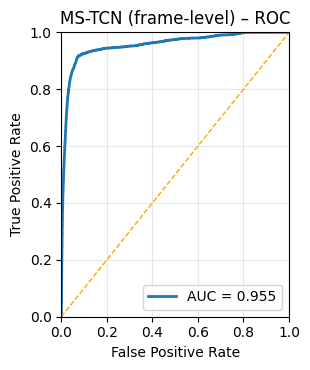

In [39]:
# y_true: 0/1 labels, y_scores: predicted probs for INTAKE:
fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
roc_auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(3.2, 3.8))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1)

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MS-TCN (frame-level) – ROC")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


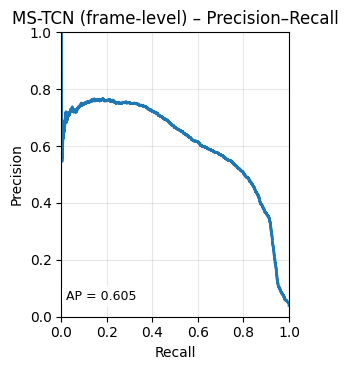

PR AUC / AP (INTAKE): 0.6053


In [40]:
# y_true: 0/1 labels, y_scores: predicted probs for INTAKE
precision, recall, _ = precision_recall_curve(y_true, y_scores, pos_label=1)
pr_ap = average_precision_score(y_true, y_scores)

plt.figure(figsize=(3.2, 3.8))
plt.plot(recall, precision, lw=2)

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("MS-TCN (frame-level) – Precision–Recall")
plt.grid(alpha=0.3)

# AP label inside the plot:
plt.text(
    0.02, 0.06,
    f"AP = {pr_ap:.3f}",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none"),
)

plt.tight_layout()
plt.show()

print(f"PR AUC / AP (INTAKE): {pr_ap:0.4f}")
